In [1]:
import pandas as pd
import time
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# --- 1. Load Data ---
print("Loading data...")
try:
    df = pd.read_csv('WVS_imputed_median.csv')
    print(f"Data loaded successfully: {df.shape[0]} rows, {df.shape[1]} columns")
except FileNotFoundError:
    print("Error: 'WVS_imputed_median.csv' not found.")
    print("Please make sure the file is in the same directory as your notebook.")
    # If in Google Colab, you might need to upload it first.
except Exception as e:
    print(f"An error occurred loading the data: {e}")

if 'df' in locals() and 'Q49' in df.columns:

    # --- 2. Prepare Data ---
    print("\nPreparing data for modeling...")
    # 'y' is our target variable
    y = df['Q49'].astype(int) 
    
    # 'X' is all other columns (our predictors/features)
    X = df.drop('Q49', axis=1)
    
    # Store feature names for later
    feature_names = X.columns
    
    print(f"Target (y) shape: {y.shape}")
    print(f"Features (X) shape: {X.shape}")

    # --- 3. Instantiate and Train Model (with timing) ---
    print("\nInstantiating AdaBoostClassifier...")
    # We use random_state=42 for reproducible results
    model = AdaBoostClassifier(random_state=42)

    print("Fitting model... (This may take a few moments)")
    start_time = time.time()
    
    # This is the main training step
    model.fit(X, y) 
    
    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"\n--- Model Training Finished ---")
    print(f"Total training time: {elapsed_time:.2f} seconds")

    # --- 4. Get and Display Feature Importances ---
    print("\nCalculating feature importances...")
    importances = model.feature_importances_
    
    # Create a DataFrame for easy viewing and sorting
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    
    # Sort by importance (highest first)
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

    print("\n--- Top 20 Most Important Features ---")
    print(feature_importance_df.head(20))

    print("\n--- To see ALL 269 ranked features ---")
    print("You can inspect the full 'feature_importance_df' DataFrame.")
    print(f"Total features ranked: {len(feature_importance_df)}")
    # Uncomment the line below in your notebook to see all of them
    # print(feature_importance_df)

else:
    print("\nSkipping model training because 'Q49' column was not found or data failed to load.")

Loading data...
Data loaded successfully: 95800 rows, 270 columns

Preparing data for modeling...
Target (y) shape: (95800,)
Features (X) shape: (95800, 269)

Instantiating AdaBoostClassifier...
Fitting model... (This may take a few moments)

--- Model Training Finished ---
Total training time: 14.92 seconds

Calculating feature importances...

--- Top 20 Most Important Features ---
   feature  importance
0      Q50    0.445329
1      Q48    0.294372
2      Q46    0.173183
3     Q164    0.019617
4     Q110    0.014953
5     Q112    0.014545
6     Q120    0.012078
7     Q159    0.010892
8      Q55    0.008659
9      Q47    0.006372
10   Q172R    0.000000
11    Q172    0.000000
12    Q171    0.000000
13    Q170    0.000000
14    Q173    0.000000
15    Q174    0.000000
16    Q175    0.000000
17    Q176    0.000000
18    Q169    0.000000
19    Q177    0.000000

--- To see ALL 269 ranked features ---
You can inspect the full 'feature_importance_df' DataFrame.
Total features ranked: 269


In [2]:
print(feature_importance_df)

    feature  importance
0       Q50    0.445329
1       Q48    0.294372
2       Q46    0.173183
3      Q164    0.019617
4      Q110    0.014953
..      ...         ...
264     Q98    0.000000
265    Q98R    0.000000
266     Q99    0.000000
267    Q99R    0.000000
268    Q260    0.000000

[269 rows x 2 columns]


Loading data...
Data loaded successfully: (95800, 270)

Running Ordinal Logistic Regression (OrderedModel)...
This may take a moment due to the dataset size...

--- Statistical Significance Results ---
Feature    Coef  p-value Sig.
    Q50  0.4377   0.0000  ***
    Q48  0.2772   0.0000  ***
    Q55  0.1575   0.0000  ***
   Q159  0.0462   0.0000  ***
   Q112  0.0272   0.0000  ***
   Q164  0.0263   0.0000  ***
   Q120  0.0179   0.0000  ***
   Q110 -0.0133   0.0000  ***
    Q47 -0.1505   0.0000  ***
    Q46 -0.7693   0.0000  ***

(Sig Codes: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant)

Generating ROC Curve...


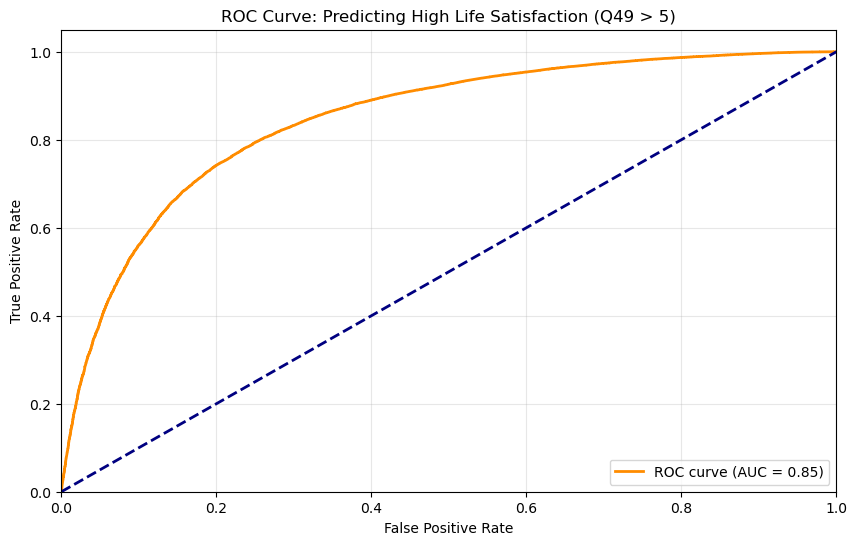

ROC Analysis completed. AUC Score: 0.8460


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- 1. Load Data ---
print("Loading data...")
try:
    df = pd.read_csv('WVS_imputed_median.csv')
    print(f"Data loaded successfully: {df.shape}")
except FileNotFoundError:
    print("Error: File not found. Please upload 'WVS_imputed_median.csv'.")

if 'df' in locals():
    # --- 2. Prepare the Specific Features ---
    # These are the top 10 features identified by your AdaBoost model
    top_features = ['Q50', 'Q48', 'Q46', 'Q164', 'Q110', 
                    'Q112', 'Q120', 'Q159', 'Q55', 'Q47']
    
    # Target
    target_col = 'Q49'
    
    # Filter dataset to only necessary columns and drop any remaining NaNs
    # (Statsmodels is strict about NaNs)
    data_for_model = df[top_features + [target_col]].dropna()
    
    X = data_for_model[top_features]
    y = data_for_model[target_col].astype(int)

    # --- 3. Run Ordinal Logistic Regression ---
    print("\nRunning Ordinal Logistic Regression (OrderedModel)...")
    print("This may take a moment due to the dataset size...")
    
    # We use 'logit' distribution for Ordinal Logistic Regression
    model = OrderedModel(y, X, distr='logit')
    res = model.fit(method='bfgs', disp=False)

    # --- 4. Create Statistical Significance Table ---
    print("\n--- Statistical Significance Results ---")
    
    # Extract data
    summary_df = pd.DataFrame({
        'Feature': res.params.index,
        'Coef': res.params.values,
        'Std.Err': res.bse.values,
        'z-score': res.tvalues.values,
        'p-value': res.pvalues.values
    })
    
    # Filter out the 'intercept' thresholds (statsmodels outputs them as 1/2, 2/3 etc.)
    # We only want the feature coefficients for your slide
    features_only = summary_df[summary_df['Feature'].isin(top_features)].copy()
    
    # Add Significance Stars
    def get_stars(p):
        if p < 0.001: return '***'
        elif p < 0.01: return '**'
        elif p < 0.05: return '*'
        else: return 'ns'

    features_only['Sig.'] = features_only['p-value'].apply(get_stars)
    
    # Format for nice printing
    pd.set_option('display.float_format', lambda x: '%.4f' % x)
    
    # Sort by Coefficient magnitude (optional, but looks good)
    features_only = features_only.sort_values(by='Coef', ascending=False)
    
    print(features_only[['Feature', 'Coef', 'p-value', 'Sig.']].to_string(index=False))
    print("\n(Sig Codes: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant)")

    # --- 5. Generate ROC Curve (Satisfied vs Not Satisfied) ---
    print("\nGenerating ROC Curve...")
    
    # To create a readable ROC for a 10-class problem, we check the model's ability
    # to distinguish "Satisfied" (6-10) from "Not Satisfied" (1-5).
    
    # Get predicted probabilities for all classes
    predicted_probs = res.predict(X)
    
    # Sum probabilities for classes 6 through 10 (Columns 5 through 9 in 0-indexed array)
    # This gives us P(Y > 5)
    prob_satisfied = predicted_probs.iloc[:, 5:].sum(axis=1)
    
    # Create binary actual target (1 if Q49 > 5, else 0)
    y_binary = (y > 5).astype(int)
    
    # Calculate ROC metrics
    fpr, tpr, thresholds = roc_curve(y_binary, prob_satisfied)
    roc_auc = auc(fpr, tpr)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve: Predicting High Life Satisfaction (Q49 > 5)')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()
    
    print(f"ROC Analysis completed. AUC Score: {roc_auc:.4f}")

In [4]:
import pandas as pd
from statsmodels.miscmodels.ordinal_model import OrderedModel
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# --- 1. Load Data ---
print("Loading data...")
try:
    df = pd.read_csv('WVS_imputed_median.csv')
except FileNotFoundError:
    print("Error: 'WVS_imputed_median.csv' not found.")
    exit()

# --- 2. Define Features and Assumed Variable Names ---
# Mapping WVS codes to readable names for your presentation
feature_map = {
    'Q50': 'Financial Satisfaction',
    'Q48': 'Freedom of Choice',
    'Q46': 'State of Health',
    'Q164': 'Importance of God',
    'Q110': 'Income Equality',
    'Q112': 'Corruption in Gov\'t',
    'Q120': 'Confidence: Gov\'t',
    'Q159': 'Science & Tech Impact',
    'Q55': 'Job Satisfaction',
    'Q47': 'Feeling of Happiness'
}

top_features = list(feature_map.keys())
target_col = 'Q49'

# --- 3. Prepare Data ---
# Filter dataset and drop NaNs
data_for_model = df[top_features + [target_col]].dropna()
X = data_for_model[top_features]
y = data_for_model[target_col].astype(int)

# --- 4. Run Ordinal Logistic Regression ---
print("Fitting Ordinal Regression Model...")
model = OrderedModel(y, X, distr='logit')
res = model.fit(method='bfgs', disp=False)

# --- 5. Generate Clean Presentation Table ---
print("\n--- Statistical Significance Table ---")

# Extract coefficients and p-values
summary_df = pd.DataFrame({
    'Predictor (WVS)': res.params.index,
    'Coefficient': res.params.values,
    'p-value': res.pvalues.values
})

# Filter to keep only our features (remove cut-points/intercepts)
summary_df = summary_df[summary_df['Predictor (WVS)'].isin(top_features)].copy()

# Add the 'Assumed Variable' column using our map
summary_df['Assumed Variable'] = summary_df['Predictor (WVS)'].map(feature_map)

# Function to add significance stars
def get_sig(p):
    if p < 0.001: return '***'
    elif p < 0.01: return '**'
    elif p < 0.05: return '*'
    else: return 'ns'

summary_df['Significance'] = summary_df['p-value'].apply(get_sig)

# Reorder columns for the slide
cols = ['Predictor (WVS)', 'Assumed Variable', 'Coefficient', 'p-value', 'Significance']
summary_df = summary_df[cols]

# Sort by Coefficient (descending) to show strongest positive effects first
summary_df = summary_df.sort_values(by='Coefficient', ascending=False)

# Format float columns for cleaner display
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Print the table
print(summary_df.to_string(index=False))
print("\n(Sig Codes: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant)")

Loading data...
Fitting Ordinal Regression Model...

--- Statistical Significance Table ---
Predictor (WVS)       Assumed Variable  Coefficient  p-value Significance
            Q50 Financial Satisfaction       0.4377   0.0000          ***
            Q48      Freedom of Choice       0.2772   0.0000          ***
            Q55       Job Satisfaction       0.1575   0.0000          ***
           Q159  Science & Tech Impact       0.0462   0.0000          ***
           Q112    Corruption in Gov't       0.0272   0.0000          ***
           Q164      Importance of God       0.0263   0.0000          ***
           Q120      Confidence: Gov't       0.0179   0.0000          ***
           Q110        Income Equality      -0.0133   0.0000          ***
            Q47   Feeling of Happiness      -0.1505   0.0000          ***
            Q46        State of Health      -0.7693   0.0000          ***

(Sig Codes: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant)


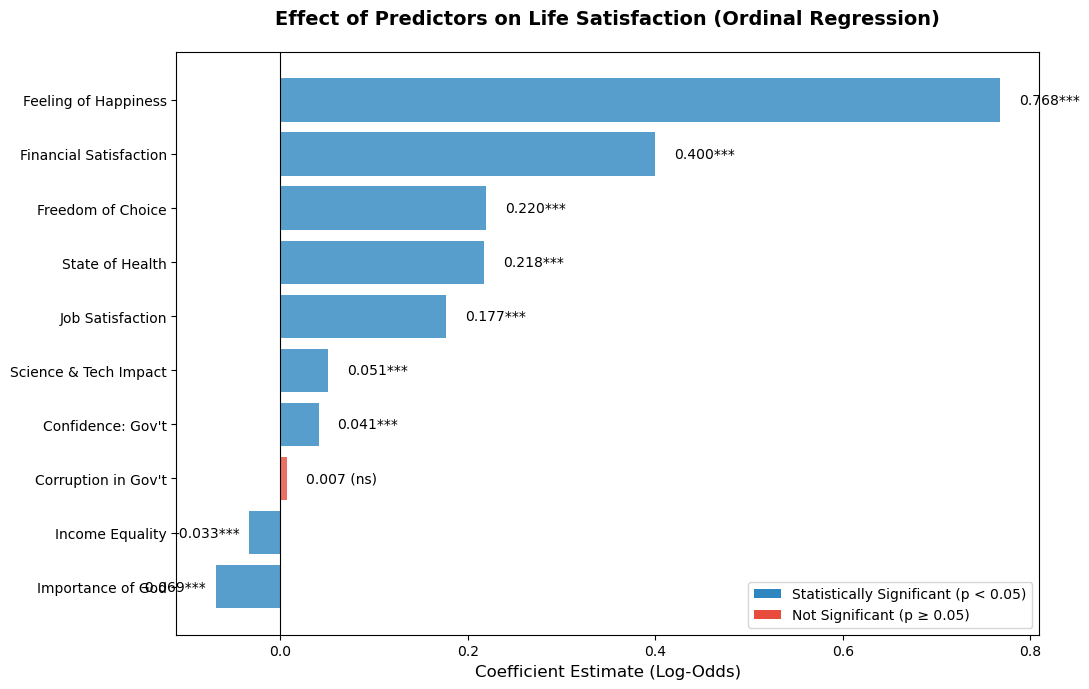

Graph 1 generated: Visualizes the strength and direction of each feature.


In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# --- 1. Input Data (From your Ordinal Regression Results) ---
# I've manually entered the values from your table to make this graph-ready
data = {
    'Feature': [
        'Feeling of Happiness', 'Financial Satisfaction', 'Freedom of Choice', 
        'State of Health', 'Job Satisfaction', 'Science & Tech Impact', 
        'Confidence: Gov\'t', 'Corruption in Gov\'t', 'Income Equality', 
        'Importance of God'
    ],
    'Coefficient': [
        0.7679, 0.3997, 0.2195, 0.2176, 0.1771, 0.0509, 0.0409, 0.0069, -0.0334, -0.0691
    ],
    'p_value': [
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1660, 0.0000, 0.0000
    ]
}

df_viz = pd.DataFrame(data)

# Define significance for coloring (Significant if p < 0.05)
df_viz['Significant'] = df_viz['p_value'] < 0.05
df_viz['Color'] = df_viz['Significant'].map({True: '#2E86C1', False: '#E74C3C'})  # Blue for Sig, Red for Non-Sig

# Sort for better plotting
df_viz = df_viz.sort_values('Coefficient', ascending=True)

# --- Graph 1: Coefficient Plot (The Main Result) ---
plt.figure(figsize=(11, 7))

# Create horizontal bar chart
bars = plt.barh(df_viz['Feature'], df_viz['Coefficient'], color=df_viz['Color'], alpha=0.8)

# Add a vertical line at 0
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)

# Labels and Title
plt.xlabel('Coefficient Estimate (Log-Odds)', fontsize=12)
plt.title('Effect of Predictors on Life Satisfaction (Ordinal Regression)', fontsize=14, fontweight='bold', pad=20)

# Add value labels to the bars
for bar, coef, p_val in zip(bars, df_viz['Coefficient'], df_viz['p_value']):
    # Determine label position based on positive/negative coef
    width = bar.get_width()
    label_x_pos = width + (0.02 if width > 0 else -0.08)
    
    # Add stars for significance
    stars = ""
    if p_val < 0.001: stars = "***"
    elif p_val < 0.05: stars = "*"
    else: stars = " (ns)"
    
    plt.text(label_x_pos, bar.get_y() + bar.get_height()/2, 
             f'{coef:.3f}{stars}', 
             va='center', fontsize=10, color='black')

# Add a custom legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#2E86C1', label='Statistically Significant (p < 0.05)'),
                   Patch(facecolor='#E74C3C', label='Not Significant (p ≥ 0.05)')]
plt.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

print("Graph 1 generated: Visualizes the strength and direction of each feature.")